# Fitting 2d Toy Datasets with the FKLD

In [1]:
# Import packages
import numpy as np
import torch
import normflow as nf
import larsflow as lf

from matplotlib import pyplot as plt

from tqdm import tqdm

In [2]:
# Get device
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')

In [12]:
# Function for model creation

def create_model(p, resampled=True):
    # Set up model

    # Define flows
    K = 16
    torch.manual_seed(0)

    latent_size = 2
    hidden_units = 32
    hidden_layers = 3
    
    flows = []
    for i in range(K):
        net = nf.nets.LipschitzMLP([latent_size] + [hidden_units] * (hidden_layers - 1) + [latent_size],
                               init_zeros=True, lipschitz_const=0.9)
        flows += [nf.flows.Residual(net, reduce_memory=True)]
        flows += [nf.flows.ActNorm(latent_size)]

    # Set prior and q0
    if resampled:
        a = nf.nets.MLP([latent_size, 256, 256, 1], output_fn="sigmoid")
        q0 = lf.distributions.ResampledGaussian(latent_size, a, 100, 0.1, trainable=False)
    else:
        n_modes = 10
        q0 = nf.distributions.GaussianMixture(n_modes, latent_size, trainable=True,
                                              loc=(np.random.rand(n_modes, latent_size) - 0.5) * 5,
                                              scale=0.5 * np.ones((n_modes, latent_size)))

    # Construct flow model
    model = lf.NormalizingFlow(q0=q0, flows=flows, p=p)

    # Move model on GPU if available
    return model.to(device)


# Function to train model

def train(model, max_iter=20000, num_samples=2 ** 10, lr=1e-3, weight_decay=1e-5, 
          q0_weight_decay=1e-4):
    optimizer = torch.optim.Adam(model.parameters(),  lr=lr, weight_decay=weight_decay)
    model.train()

    for it in tqdm(range(max_iter)):
        
        x = model.p.sample(num_samples)

        loss = model.forward_kld(x)

        loss.backward()
        optimizer.step()
        
        # Make layers Lipschitz continuous
        nf.utils.update_lipschitz(model, 5)

        # Clear gradients
        nf.utils.clear_grad(model)

In [4]:
# Plot function
def plot_results(model, target=True, a=False, save=False, prefix=''):
    # Prepare z grid for evaluation
    grid_size = 300
    xx, yy = torch.meshgrid(torch.linspace(-3, 3, grid_size), torch.linspace(-3, 3, grid_size))
    zz = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2).view(-1, 2)
    zz = zz.to(device)
    
    log_prob = model.p.log_prob(zz).to('cpu').view(*xx.shape)
    prob = torch.exp(log_prob)
    prob[torch.isnan(prob)] = 0
    prob_target = prob.data.numpy()
    
    if target:
        plt.figure(figsize=(15, 15))
        plt.pcolormesh(xx, yy, prob_target)
        plt.gca().set_aspect('equal', 'box')
        plt.axis('off')
        if save:
            plt.savefig(prefix + 'target.png', dpi=300)
        plt.show()

    nf.utils.update_lipschitz(model, 200)
    with torch.no_grad():
        model.eval()
        log_prob = []
        for zz_ in torch.split(zz, 1024):
            log_prob.append(model.log_prob(zz_).to('cpu'))
        log_prob = torch.cat(log_prob).view(*xx.shape)

        prob = torch.exp(log_prob.to('cpu').view(*xx.shape))
        prob[torch.isnan(prob)] = 0
        prob_model = prob.data.numpy()

    plt.figure(figsize=(15, 15))
    plt.pcolormesh(xx, yy, prob_model)
    plt.gca().set_aspect('equal')
    plt.axis('off')
    if save:
        plt.savefig(prefix + 'model.png', dpi=300)
    plt.show()

    log_prob = model.q0.log_prob(zz).to('cpu').view(*xx.shape)
    prob = torch.exp(log_prob)
    prob[torch.isnan(prob)] = 0

    plt.figure(figsize=(15, 15))
    plt.pcolormesh(xx, yy, prob.data.numpy())
    plt.gca().set_aspect('equal')
    plt.axis('off')
    if save:
        plt.savefig(prefix + 'base.png', dpi=300)
    plt.show()
    
    if a:
        prob = model.q0.a(zz).to('cpu').view(*xx.shape)
        prob[torch.isnan(prob)] = 0

        plt.figure(figsize=(15, 15))
        plt.pcolormesh(xx, yy, prob.data.numpy())
        plt.gca().set_aspect('equal')
        plt.axis('off')
        if save:
            plt.savefig(prefix + 'a.png', dpi=300)
        plt.show()
    
    # Compute KLD
    eps = 1e-10
    kld = np.sum(prob_target * np.log((prob_target + eps) / (prob_model + eps)) * 6 ** 2 / grid_size ** 2)
    print(kld)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [12:08<00:00,  6.86it/s]
/tmp/ipykernel_80735/3925255946.py:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, prob_target)


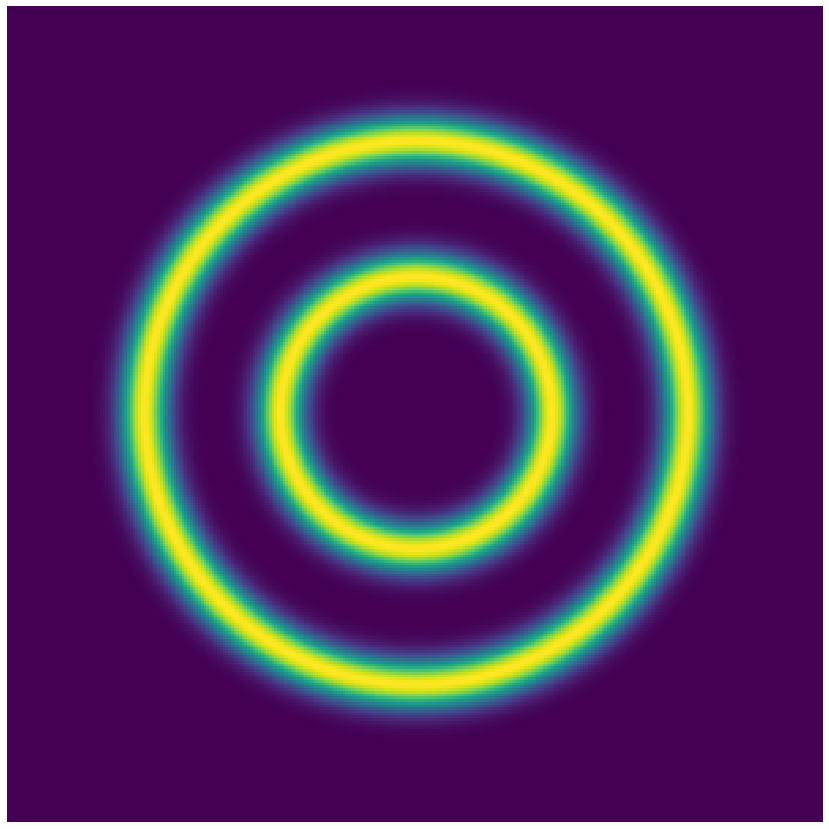

/tmp/ipykernel_80735/3925255946.py:36: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, prob_model)


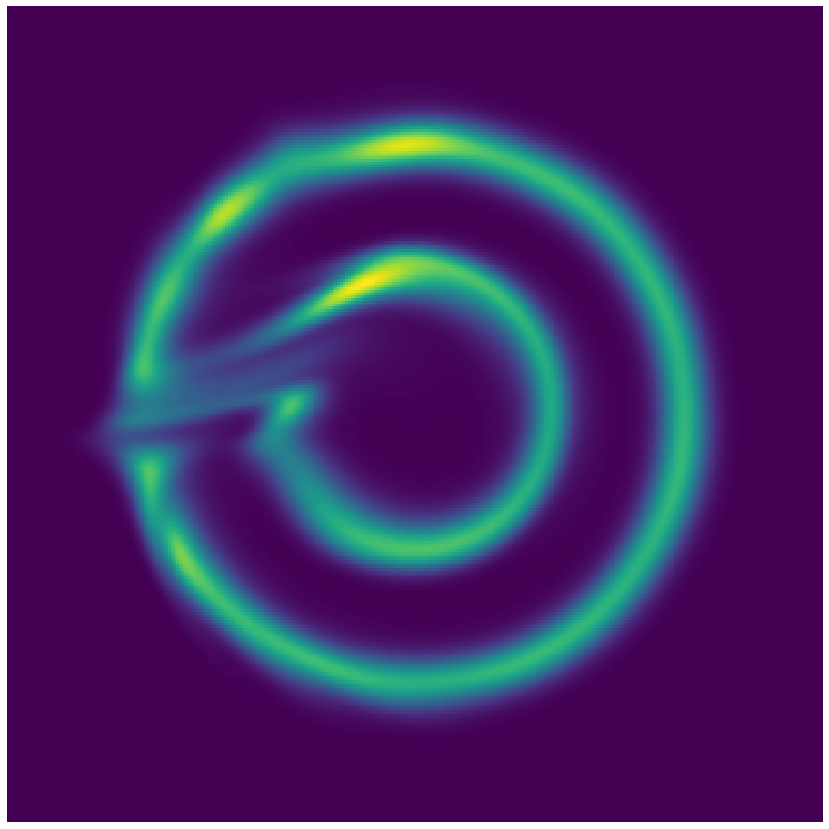

/tmp/ipykernel_80735/3925255946.py:48: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, prob.data.numpy())


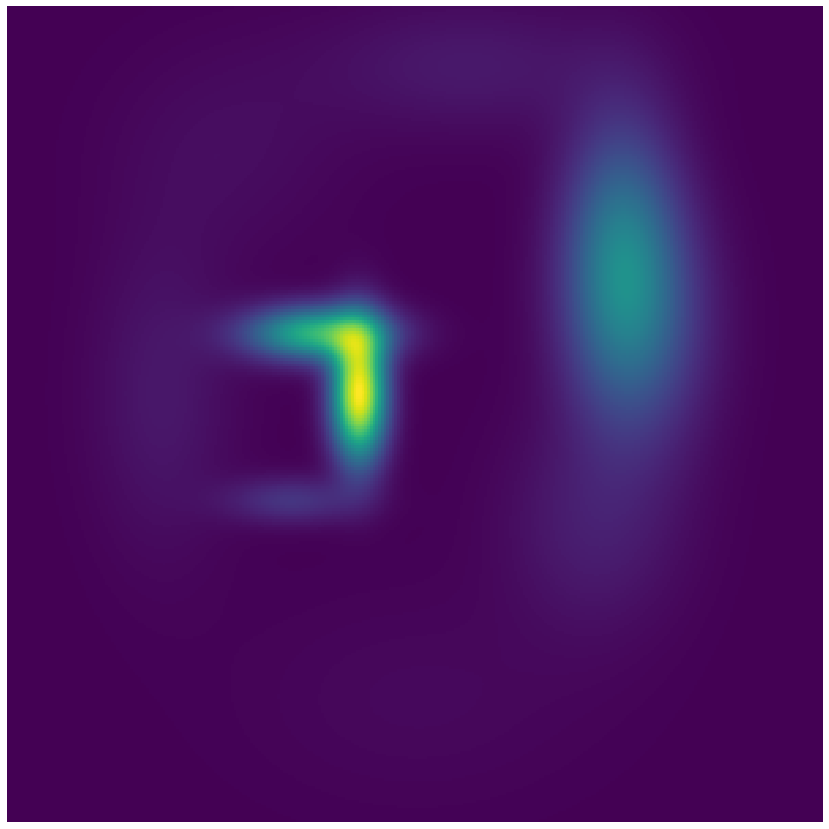

10.812643785981397


In [16]:
# Train models
p = [nf.distributions.RingMixture()] #[nf.distributions.TwoMoons(), nf.distributions.CircularGaussianMixture(), nf.distributions.RingMixture()]
name = ['rings'] #['moons', 'circle', 'rings']

for i in range(len(p)):
    # Train model with Gaussain base distribution
    #model = create_model(p[i], False)
    train(model, weight_decay=1e-3, max_iter=5000)
    # Plot and save results
    plot_results(model, save=True,
                 prefix='/raven/u/vstimper/projects/resampled-base-flows/plots/2d_distributions/gaussian_mixture/resflow/' 
                 + name[i] + '_mixture_')